In [1]:
# Choose either Re=1000 or Re=100
Re=10000

# FOM

In [2]:
import numpy as np
from scipy import sparse as sp
from scipy.sparse.linalg import spsolve
from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import time, sys
import pickle
from scipy.io import savemat

In [3]:
np.set_printoptions(threshold=sys.maxsize)

In [4]:
# Set parameters
if Re==10000:
    nx=60
    ny=60
    nt=1500
elif Re==100:
    nx=60
    ny=60
    nt=1500
else:
    raise NameError('{} is given for Re, but it must be either 100 or 10000'.format(Re))
    
nxy=(nx-2)*(ny-2)
dx=1/(nx-1)
dy=1/(ny-1)
dt=2/nt

maxitr=10
tol=1e-8

I=sp.eye(nxy,format='csr')

# full indicies, free indicies, fixed indicies
[xv,yv]=np.meshgrid(np.linspace(0,1,nx),np.linspace(0,1,ny),indexing='xy')
x=xv.flatten()
y=yv.flatten()

multi_index_i,multi_index_j=np.meshgrid(np.arange(nx),np.arange(ny),indexing='xy')
full_multi_index=(multi_index_j.flatten(),multi_index_i.flatten())
free_multi_index=(multi_index_j[1:-1,1:-1].flatten(),multi_index_i[1:-1,1:-1].flatten())
x0_multi_index=(multi_index_j[1:-1,0].flatten(),multi_index_i[1:-1,0].flatten())
x1_multi_index=(multi_index_j[1:-1,-1].flatten(),multi_index_i[1:-1,-1].flatten())
y0_multi_index=(multi_index_j[0,1:-1].flatten(),multi_index_i[0,1:-1].flatten())
y1_multi_index=(multi_index_j[-1,1:-1].flatten(),multi_index_i[-1,1:-1].flatten())

dims=(ny,nx)
full_raveled_indicies=np.ravel_multi_index(full_multi_index,dims)
free_raveled_indicies=np.ravel_multi_index(free_multi_index,dims)
x0_raveled_indicies=np.ravel_multi_index(x0_multi_index,dims)
x1_raveled_indicies=np.ravel_multi_index(x1_multi_index,dims)
x01_raveled_indicies=np.concatenate((x0_raveled_indicies,x1_raveled_indicies))
y0_raveled_indicies=np.ravel_multi_index(y0_multi_index,dims)
y1_raveled_indicies=np.ravel_multi_index(y1_multi_index,dims)
y01_raveled_indicies=np.concatenate((y0_raveled_indicies,y1_raveled_indicies))
fixed_raveled_indicies=np.setdiff1d(full_raveled_indicies,free_raveled_indicies)

# boundary one-hot vector
x0_one_hot=np.eye(nx-2)[0]
y0_one_hot=np.eye(ny-2)[0]
x1_one_hot=np.eye(nx-2)[-1]
y1_one_hot=np.eye(ny-2)[-1]

# inner grid
inner_multi_index_i,inner_multi_index_j=np.meshgrid(np.arange(nx-2),np.arange(ny-2),indexing='xy')
inner_x_multi_index=(np.concatenate((inner_multi_index_j[:,0].flatten(),inner_multi_index_j[:,-1].flatten())),
                     np.concatenate((inner_multi_index_i[:,0].flatten(),inner_multi_index_i[:,-1].flatten())))
inner_y_multi_index=(np.concatenate((inner_multi_index_j[0,:].flatten(),inner_multi_index_j[-1,:].flatten())),
                     np.concatenate((inner_multi_index_i[0,:].flatten(),inner_multi_index_i[-1,:].flatten())))

inner_dims=(ny-2,nx-2)
inner_x_raveled_indicies=np.ravel_multi_index(inner_x_multi_index,inner_dims)
inner_y_raveled_indicies=np.ravel_multi_index(inner_y_multi_index,inner_dims)

In [5]:
# first order derivative
# central
Mb=sp.diags([np.ones(nx-2),-np.ones(nx-2)],[0,-1],(nx-2,nx-2))
M=sp.kron(sp.eye(ny-2),Mb,format="csr")

Ib=sp.eye(nx-2)
N=sp.kron(sp.diags([np.ones(ny-2),-np.ones(ny-2)],[0,-1],(ny-2,ny-2)),Ib,format="csr")

# laplacian operator
Dxb=sp.diags([-2*np.ones(nx-2),np.ones(nx-2),np.ones(nx-2)],[0,-1,1],(nx-2,nx-2))
Dx=sp.kron(sp.eye(ny-2),Dxb,format="csr")

Ib=sp.eye(nx-2)
Dy=sp.kron(sp.diags([-2*np.ones(ny-2),np.ones(ny-2),np.ones(ny-2)],[0,-1,1],(ny-2,ny-2)),Ib,format="csr")

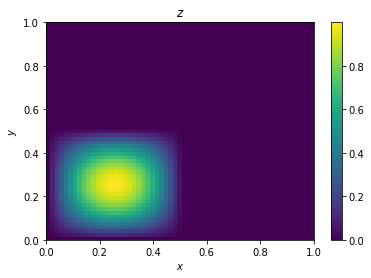

In [6]:
# IC
zv=np.sin(2*np.pi*xv)*np.sin(2*np.pi*yv)
zv[np.nonzero(xv>0.5)]=0.0
zv[np.nonzero(yv>0.5)]=0.0
z=zv.flatten()

fig_z = plt.figure()
# ax_z = Axes3D(fig_z)
# ax_z.plot_surface(xv, yv, zv,cmap=cm.viridis, rstride=1, cstride=1)
# ax_z.view_init(elev=30,azim=60)
ax_z = fig_z.gca()
p_z=ax_z.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), z.reshape(ny,nx))
cb_z=fig_z.colorbar(p_z,ax=ax_z)
ax_z.set_xlabel('$x$')
ax_z.set_ylabel('$y$')
plt.title('$z$')
plt.show()

u0=z.copy()
v0=z.copy()

In [7]:
# boundary for first order derivative term
Bdudx0_cur=np.kron(u0[x0_raveled_indicies],x0_one_hot)
Bdudy0_cur=np.kron(y0_one_hot,u0[y0_raveled_indicies])
Bdvdx0_cur=np.kron(v0[x0_raveled_indicies],x0_one_hot)
Bdvdy0_cur=np.kron(y0_one_hot,v0[y0_raveled_indicies])
Bdudx1_cur=np.kron(u0[x1_raveled_indicies],x1_one_hot)
Bdudy1_cur=np.kron(y1_one_hot,u0[y1_raveled_indicies])
Bdvdx1_cur=np.kron(v0[x1_raveled_indicies],x1_one_hot)
Bdvdy1_cur=np.kron(y1_one_hot,v0[y1_raveled_indicies])
    
# boundary for second order derivative term
bxu_cur=np.zeros(nxy)
byu_cur=np.zeros(nxy)
bxv_cur=np.zeros(nxy)
byv_cur=np.zeros(nxy)

bxu_cur[inner_x_raveled_indicies]=u0[x01_raveled_indicies]
byu_cur[inner_y_raveled_indicies]=u0[y01_raveled_indicies]
bxv_cur[inner_x_raveled_indicies]=v0[x01_raveled_indicies]
byv_cur[inner_y_raveled_indicies]=v0[y01_raveled_indicies]

In [8]:
def r(u_free,v_free,u_free_prev,v_free_prev,Mu_free,Mv_free,Nu_free,Nv_free,
      Bdudx0_cur,Bdvdx0_cur,Bdudx1_cur,Bdvdx1_cur,Bdudy0_cur,Bdvdy0_cur,Bdudy1_cur,Bdvdy1_cur,
      bxu_cur,bxv_cur,byu_cur,byv_cur):
    
    f_u=(-1/dx*(u_free*(Mu_free - Bdudx0_cur))
    -1/dy*(v_free*(Nu_free - Bdudy0_cur))
    +1/(Re*dx**2)*(Dx.dot(u_free) + bxu_cur)
    +1/(Re*dy**2)*(Dy.dot(u_free) + byu_cur))
    f_v=(-1/dx*(u_free*(Mv_free - Bdvdx0_cur))
    -1/dy*(v_free*(Nv_free - Bdvdy0_cur))
    +1/(Re*dx**2)*(Dx.dot(v_free) + bxv_cur)
    +1/(Re*dy**2)*(Dy.dot(v_free) + byv_cur))
        
    r_u=u_free-u_free_prev-dt*f_u
    r_v=v_free-v_free_prev-dt*f_v
    
    return np.concatenate((r_u,r_v))



def J(u_free,v_free,Mu_free,Mv_free,Nu_free,Nv_free,
      Bdudx0_cur,Bdvdx0_cur,Bdudx1_cur,Bdvdx1_cur,Bdudy0_cur,Bdvdy0_cur,Bdudy1_cur,Bdvdy1_cur):
    
    df_udu = (-1/dx*(sp.diags(Mu_free - Bdudx0_cur,0,(nxy,nxy),format="csr") 
                        + sp.diags(u_free,0,(nxy,nxy),format="csr").dot(M))
    -1/dy*sp.diags(v_free,0,(nxy,nxy),format="csr").dot(N)
    +1/(Re*dx**2)*Dx
    +1/(Re*dy**2)*Dy)
    df_udv = -1/dy*sp.diags(Nu_free - Bdudy0_cur,0,(nxy,nxy),format="csr")
    df_vdu = -1/dx*sp.diags(Mv_free - Bdvdx0_cur,0,(nxy,nxy),format="csr")
    df_vdv = (-1/dx*sp.diags(u_free,0,(nxy,nxy),format="csr").dot(M)
    -1/dy*(sp.diags(Nv_free - Bdvdy0_cur,0,(nxy,nxy),format="csr")
               + sp.diags(v_free,0,(nxy,nxy),format="csr").dot(N))
    +1/(Re*dx**2)*Dx
    +1/(Re*dy**2)*Dy)
    
    return sp.bmat([[I-dt*df_udu,-dt*df_udv],[-dt*df_vdu,I-dt*df_vdv]],format='csr')

In [9]:
t_start=time.time()

# solution snapshot
u_full=np.zeros(((nt+1),ny*nx))
v_full=np.zeros(((nt+1),ny*nx))

# IC
u_full[0]=np.copy(u0)
v_full[0]=np.copy(v0)
u0_free=u0[free_raveled_indicies]
v0_free=v0[free_raveled_indicies]

for k in range(nt):
#     print("")
#     print(k,"th time step:")
    
    u_free_prev=np.copy(u_full[k,free_raveled_indicies])
    v_free_prev=np.copy(v_full[k,free_raveled_indicies])
    
    u_free=np.copy(u_full[k,free_raveled_indicies])
    v_free=np.copy(v_full[k,free_raveled_indicies])

    Mu_free=M.dot(u_free)
    Mv_free=M.dot(v_free)
    Nu_free=N.dot(u_free)
    Nv_free=N.dot(v_free)
    
    residual=r(u_free,v_free,u_free_prev,v_free_prev,Mu_free,Mv_free,Nu_free,Nv_free,
               Bdudx0_cur,Bdvdx0_cur,Bdudx1_cur,Bdvdx1_cur,Bdudy0_cur,Bdvdy0_cur,Bdudy1_cur,Bdvdy1_cur,
               bxu_cur,bxv_cur,byu_cur,byv_cur)
    
    for itr in range(maxitr):
        jacobian=J(u_free,v_free,Mu_free,Mv_free,Nu_free,Nv_free,
                   Bdudx0_cur,Bdvdx0_cur,Bdudx1_cur,Bdvdx1_cur,Bdudy0_cur,Bdvdy0_cur,Bdudy1_cur,Bdvdy1_cur)
        
        delta_free=spsolve(jacobian, -residual)
        
        u_free+=delta_free[:nxy]
        v_free+=delta_free[nxy:]

        Mu_free=M.dot(u_free)
        Mv_free=M.dot(v_free)
        Nu_free=N.dot(u_free)
        Nv_free=N.dot(v_free)
        
        residual=r(u_free,v_free,u_free_prev,v_free_prev,Mu_free,Mv_free,Nu_free,Nv_free,
                   Bdudx0_cur,Bdvdx0_cur,Bdudx1_cur,Bdvdx1_cur,Bdudy0_cur,Bdvdy0_cur,Bdudy1_cur,Bdvdy1_cur,
                   bxu_cur,bxv_cur,byu_cur,byv_cur)

        R=np.linalg.norm(residual)
#         print(itr,"th Newton iteration", "R:", R)
        
        if R<tol:
            u_full[k+1,free_raveled_indicies]=np.copy(u_free)
            v_full[k+1,free_raveled_indicies]=np.copy(v_free)
            # BC from exact solution
            u_full[k+1,fixed_raveled_indicies]=np.copy(u0[fixed_raveled_indicies])
            v_full[k+1,fixed_raveled_indicies]=np.copy(v0[fixed_raveled_indicies])
            break
            
    if R>=tol:
        print("\n non converged after {}th iteration".format(maxitr))
        break     

#     u_full[k+1,free_raveled_indicies]=np.copy(u_free)
#     v_full[k+1,free_raveled_indicies]=np.copy(v_free)
#     # BC from exact solution
#     u_full[k+1,fixed_raveled_indicies]=np.copy(u0[fixed_raveled_indicies])
#     v_full[k+1,fixed_raveled_indicies]=np.copy(v0[fixed_raveled_indicies])

t_elapsed=time.time()-t_start
print()
print('Time elapsed: {} sec'.format(t_elapsed))


Time elapsed: 143.7600176334381 sec


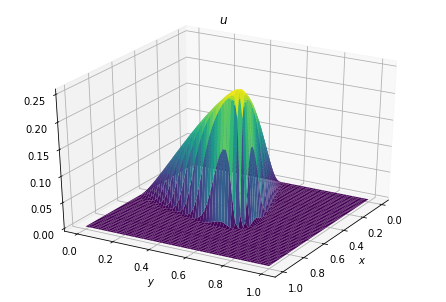

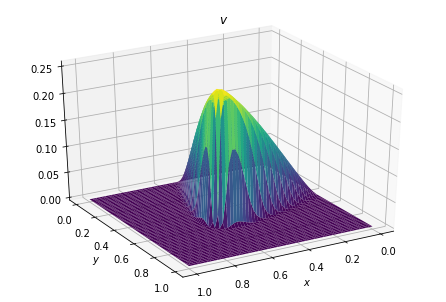

In [10]:
# plot
fig_u = plt.figure()
ax_u = Axes3D(fig_u)
ax_u.plot_surface(x.reshape(ny,nx), y.reshape(ny,nx), u_full[-1].reshape(ny,nx),cmap=cm.viridis, rstride=1, cstride=1)
ax_u.view_init(elev=30,azim=30)
# ax_u = fig_u.gca()
# p_u=ax_u.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), (u_full[-1]).reshape(ny,nx))
# cb_u=fig_u.colorbar(p_u,ax=ax_u)
ax_u.set_xlabel('$x$')
ax_u.set_ylabel('$y$')
plt.title('$u$')
plt.show()

fig_v = plt.figure()
ax_v = Axes3D(fig_v)
ax_v.plot_surface(x.reshape(ny,nx), y.reshape(ny,nx), v_full[-1].reshape(ny,nx),cmap=cm.viridis, rstride=1, cstride=1)
ax_v.view_init(elev=30,azim=60)
# ax_v = fig_v.gca()
# p_v=ax_v.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), (v_full[-1]).reshape(ny,nx))
# cb_v=fig_v.colorbar(p_v,ax=ax_v)
ax_v.set_xlabel('$x$')
ax_v.set_ylabel('$y$')
plt.title('$v$')
plt.show()

# Galerkin

In [11]:
if Re==10000:
    POD_basis=5
    file_name_POD="./model/POD_high_Re.p"
elif Re==100:
    POD_basis=5
    file_name_POD="./model/POD_low_Re.p"
else:
    raise NameError('{} is given for Re, but it must be either 100 or 10000'.format(Re))

POD = pickle.load(open(file_name_POD,'rb'))

phi_u = POD['u']
phi_v = POD['v']

phi_u_pinv=np.linalg.pinv(phi_u)
phi_v_pinv=np.linalg.pinv(phi_v)

u_ref = u0[free_raveled_indicies]
v_ref = v0[free_raveled_indicies]

I_hat=np.eye(POD_basis)

maxitr=10
tol=1e-8

In [12]:
Mu_ref=M.dot(u_ref)
Nu_ref=N.dot(u_ref)
Mv_ref=M.dot(v_ref)
Nv_ref=N.dot(v_ref)

Dxu_ref=Dx.dot(u_ref)
Dyu_ref=Dy.dot(u_ref)
Dxv_ref=Dx.dot(v_ref)
Dyv_ref=Dy.dot(v_ref)

Mphi_u=M.dot(phi_u)
Nphi_u=N.dot(phi_u)
Mphi_v=M.dot(phi_v)
Nphi_v=N.dot(phi_v)

Dxphi_u=Dx.dot(phi_u)
Dyphi_u=Dy.dot(phi_u)
Dxphi_v=Dx.dot(phi_v)
Dyphi_v=Dy.dot(phi_v)

In [13]:
au_cur=-1/dx*u_ref*(Mu_ref-Bdudx0_cur)-1/dy*v_ref*(Nu_ref-Bdudy0_cur) \
+1/(Re*dx**2)*(Dxu_ref+bxu_cur)+1/(Re*dy**2)*(Dyu_ref+byu_cur)
Bu_cur=-1/dx*(np.diag(u_ref).dot(Mphi_u)+np.diag(Mu_ref-Bdudx0_cur).dot(phi_u)) \
-1/dy*np.diag(v_ref).dot(Nphi_u) \
+1/(Re*dx**2)*Dxphi_u+1/(Re*dy**2)*Dyphi_u
Cu_cur=-1/dy*np.diag(Nu_ref-Bdudy0_cur).dot(phi_v) 

av_cur=-1/dx*u_ref*(Mv_ref-Bdvdx0_cur)-1/dy*v_ref*(Nv_ref-Bdvdy0_cur) \
+1/(Re*dx**2)*(Dxv_ref+bxv_cur)+1/(Re*dy**2)*(Dyv_ref+byv_cur)
Bv_cur=-1/dx*np.diag(Mv_ref-Bdvdx0_cur).dot(phi_u)
Cv_cur=-1/dx*np.diag(u_ref).dot(Mphi_v) \
-1/dy*(np.diag(v_ref).dot(Nphi_v)+np.diag(Nv_ref-Bdvdy0_cur).dot(phi_v)) \
+1/(Re*dx**2)*Dxphi_v+1/(Re*dy**2)*Dyphi_v

In [14]:
a1_cur=phi_u_pinv.dot(au_cur)
A2_cur=phi_u_pinv.dot(Bu_cur)
A3_cur=phi_u_pinv.dot(Cu_cur)

b1_cur=phi_v_pinv.dot(av_cur)
B2_cur=phi_v_pinv.dot(Bv_cur)
B3_cur=phi_v_pinv.dot(Cv_cur)

In [15]:
def theta_u(u_hat,v_hat):
    return -1/dx*phi_u.dot(u_hat)*Mphi_u.dot(u_hat)-1/dy*phi_v.dot(v_hat)*Nphi_u.dot(u_hat)

def theta_v(u_hat,v_hat):
    return -1/dx*phi_u.dot(u_hat)*Mphi_v.dot(v_hat)-1/dy*phi_v.dot(v_hat)*Nphi_v.dot(v_hat)

In [16]:
def dtheta_udu_hat(u_hat,v_hat):
    return -1/dx*(np.diag(Mphi_u.dot(u_hat)).dot(phi_u)+np.diag(phi_u.dot(u_hat)).dot(Mphi_u)) \
-1/dy*(np.diag(phi_v.dot(v_hat)).dot(Nphi_u))

def dtheta_udv_hat(u_hat,v_hat):
    return -1/dy*(np.diag(Nphi_u.dot(u_hat)).dot(phi_v))

def dtheta_vdu_hat(u_hat,v_hat):
    return -1/dx*(np.diag(Mphi_v.dot(v_hat)).dot(phi_u))

def dtheta_vdv_hat(u_hat,v_hat):
    return -1/dx*(np.diag(phi_u.dot(u_hat)).dot(Mphi_v)) \
-1/dy*(np.diag(Nphi_v.dot(v_hat)).dot(phi_v)+np.diag(phi_v.dot(v_hat)).dot(Nphi_v))

In [17]:
def f_u_hat(u_hat,v_hat,a1_cur,A2_cur,A3_cur):
    return a1_cur+A2_cur.dot(u_hat)+A3_cur.dot(v_hat)+phi_u_pinv.dot(theta_u(u_hat,v_hat))

def f_v_hat(u_hat,v_hat,b1_cur,B2_cur,B3_cur):
    return b1_cur+B2_cur.dot(u_hat)+B3_cur.dot(v_hat)+phi_v_pinv.dot(theta_v(u_hat,v_hat))

In [18]:
def df_u_hatdu_hat(u_hat,v_hat,A2_cur):
    return A2_cur+phi_u_pinv.dot(dtheta_udu_hat(u_hat,v_hat))

def df_u_hatdv_hat(u_hat,v_hat,A3_cur):
    return A3_cur+phi_u_pinv.dot(dtheta_udv_hat(u_hat,v_hat))

def df_v_hatdu_hat(u_hat,v_hat,B2_cur):
    return B2_cur+phi_v_pinv.dot(dtheta_vdu_hat(u_hat,v_hat))

def df_v_hatdv_hat(u_hat,v_hat,B3_cur):
    return B3_cur+phi_v_pinv.dot(dtheta_vdv_hat(u_hat,v_hat))

In [19]:
def r_hat(u_hat,v_hat,u_hat_prev,v_hat_prev,a1_cur,A2_cur,A3_cur,b1_cur,B2_cur,B3_cur):
    r_u_hat=u_hat-u_hat_prev-dt*f_u_hat(u_hat,v_hat,a1_cur,A2_cur,A3_cur)
    r_v_hat=v_hat-v_hat_prev-dt*f_v_hat(u_hat,v_hat,b1_cur,B2_cur,B3_cur)
    return np.concatenate((r_u_hat,r_v_hat))

In [20]:
def J_hat(u_hat,v_hat,A2_cur,A3_cur,B2_cur,B3_cur):
    J_hat11=I_hat-dt*df_u_hatdu_hat(u_hat,v_hat,A2_cur)
    J_hat12=-dt*df_u_hatdv_hat(u_hat,v_hat,A3_cur)
    J_hat21=-dt*df_v_hatdu_hat(u_hat,v_hat,B2_cur)
    J_hat22=I_hat-dt*df_v_hatdv_hat(u_hat,v_hat,B3_cur)
    return np.block([[J_hat11,J_hat12],[J_hat21,J_hat22]])

In [21]:
t_start_g=time.time()

# solution
u_rom_g=np.zeros((nt+1,ny*nx))
v_rom_g=np.zeros((nt+1,ny*nx))
u_reduced=np.zeros((nt+1,POD_basis))
v_reduced=np.zeros((nt+1,POD_basis))

# IC
u_hat0=np.zeros(POD_basis)
v_hat0=np.zeros(POD_basis)
u_rom_g[0]=np.copy(u0)
v_rom_g[0]=np.copy(v0)

for k in range(nt):
#     print("")
#     print(k,"th time step:")
    
    u_hat_prev=np.copy(u_reduced[k])
    v_hat_prev=np.copy(v_reduced[k])
    
    u_hat=np.copy(u_reduced[k])
    v_hat=np.copy(v_reduced[k])
    
    residual_hat=r_hat(u_hat,v_hat,u_hat_prev,v_hat_prev,a1_cur,A2_cur,A3_cur,b1_cur,B2_cur,B3_cur)
    
    for itr in range(maxitr):
        Jacobian_hat=J_hat(u_hat,v_hat,A2_cur,A3_cur,B2_cur,B3_cur)
        
        delta_reduced=np.linalg.solve(Jacobian_hat,-residual_hat)
        
        u_hat+=delta_reduced[:POD_basis]
        v_hat+=delta_reduced[POD_basis:]
        
        residual_hat=r_hat(u_hat,v_hat,u_hat_prev,v_hat_prev,a1_cur,A2_cur,A3_cur,b1_cur,B2_cur,B3_cur)
        
        R=np.linalg.norm(residual_hat)
#         print(itr,"th Newton iteration", "R:", R)
        
        if R<tol:
            u_reduced[k+1]=u_hat.copy()
            v_reduced[k+1]=v_hat.copy()
            u_rom_g[k+1,free_raveled_indicies]=u_ref+phi_u.dot(u_hat)
            v_rom_g[k+1,free_raveled_indicies]=v_ref+phi_v.dot(v_hat)
            # BC from exact solution
            u_rom_g[k+1,fixed_raveled_indicies]=u0[fixed_raveled_indicies].copy()
            v_rom_g[k+1,fixed_raveled_indicies]=v0[fixed_raveled_indicies].copy()
            break
            
    if R>=tol:
        print("\n non converged after {}th iteration".format(maxitr))
        break  

#     u_reduced[k+1]=u_hat.copy()
#     v_reduced[k+1]=v_hat.copy()
#     u_rom_g[k+1,free_raveled_indicies]=u_ref+phi_u.dot(u_hat)
#     v_rom_g[k+1,free_raveled_indicies]=v_ref+phi_v.dot(v_hat)
#     # BC from exact solution
#     u_rom_g[k+1,fixed_raveled_indicies]=u0[fixed_raveled_indicies].copy()
#     v_rom_g[k+1,fixed_raveled_indicies]=v0[fixed_raveled_indicies].copy()

t_elapsed_g=time.time()-t_start_g
print()
print('Time elapsed: {} sec'.format(t_elapsed_g))


Time elapsed: 519.116635799408 sec


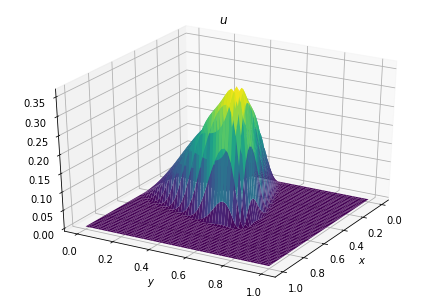

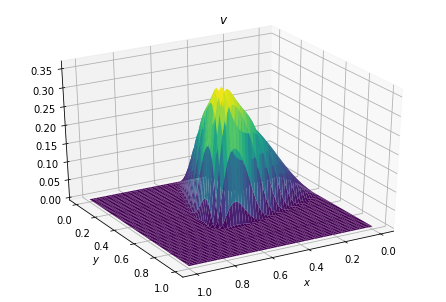

In [22]:
# plot
fig_u = plt.figure()
ax_u = Axes3D(fig_u)
ax_u.plot_surface(x.reshape(ny,nx), y.reshape(ny,nx), u_rom_g[-1].reshape(ny,nx),cmap=cm.viridis, rstride=1, cstride=1)
ax_u.view_init(elev=30,azim=30)
ax_u.set_xlabel('$x$')
ax_u.set_ylabel('$y$')
plt.title('$u$')
plt.show()

fig_v = plt.figure()
ax_v = Axes3D(fig_v)
ax_v.plot_surface(x.reshape(ny,nx), y.reshape(ny,nx), v_rom_g[-1].reshape(ny,nx),cmap=cm.viridis, rstride=1, cstride=1)
ax_v.view_init(elev=30,azim=60)
ax_v.set_xlabel('$x$')
ax_v.set_ylabel('$y$')
plt.title('$v$')
plt.show()

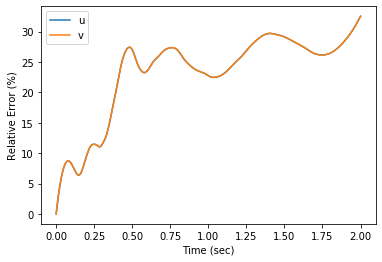

average relative error of u: 19.5543402824846%
average relative error of v: 19.554340282484574%

maximum relative error of u: 32.53289442307051%
maximum relative error of v: 32.532894423070616%


In [23]:
u_rel_err=np.linalg.norm(u_full-u_rom_g,ord=2,axis=1)/np.linalg.norm(u_full,ord=2,axis=1)*100
v_rel_err=np.linalg.norm(v_full-v_rom_g,ord=2,axis=1)/np.linalg.norm(v_full,ord=2,axis=1)*100
plt.plot(dt*np.arange(nt+1),u_rel_err,dt*np.arange(nt+1),v_rel_err)
plt.xlabel('Time (sec)')
plt.ylabel('Relative Error (%)')
plt.legend(('u','v'))
plt.show()

u_avg_rel_err=np.sqrt(np.sum(np.linalg.norm(u_full-u_rom_g,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(u_full,ord=2,axis=1)**2))*100
v_avg_rel_err=np.sqrt(np.sum(np.linalg.norm(v_full-v_rom_g,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(v_full,ord=2,axis=1)**2))*100

print("average relative error of u: {}%".format(u_avg_rel_err))
print("average relative error of v: {}%".format(v_avg_rel_err))
print()
print("maximum relative error of u: {}%".format(np.max(u_rel_err)))
print("maximum relative error of v: {}%".format(np.max(v_rel_err)))

In [24]:
# speed-up
speed_up=t_elapsed/t_elapsed_g
print("speed-up: {}".format(speed_up))

speed-up: 0.25194474778777776


# LSPG

In [21]:
if Re==10000:
    POD_basis=5
    file_name_POD="./model/POD_high_Re.p"
elif Re==100:
    POD_basis=5
    file_name_POD="./model/POD_low_Re.p"
else:
    raise NameError('{} is given for Re, but it must be either 100 or 10000'.format(Re))

POD = pickle.load(open(file_name_POD,'rb'))

phi_u = POD['u']
phi_v = POD['v']

phi_uT=phi_u.T
phi_vT=phi_v.T

phi_u_pinv=np.linalg.pinv(phi_u)
phi_v_pinv=np.linalg.pinv(phi_v)

u_ref = u0[free_raveled_indicies]
v_ref = v0[free_raveled_indicies]

I_hat=np.eye(POD_basis)

maxitr=10
tol=1e-8

In [22]:
Mu_ref=M.dot(u_ref)
Nu_ref=N.dot(u_ref)
Mv_ref=M.dot(v_ref)
Nv_ref=N.dot(v_ref)

Dxu_ref=Dx.dot(u_ref)
Dyu_ref=Dy.dot(u_ref)
Dxv_ref=Dx.dot(v_ref)
Dyv_ref=Dy.dot(v_ref)

Mphi_u=M.dot(phi_u)
Nphi_u=N.dot(phi_u)
Mphi_v=M.dot(phi_v)
Nphi_v=N.dot(phi_v)

Mphi_uT=Mphi_u.T
Nphi_uT=Nphi_u.T
Mphi_vT=Mphi_v.T
Nphi_vT=Nphi_v.T

Dxphi_u=Dx.dot(phi_u)
Dyphi_u=Dy.dot(phi_u)
Dxphi_v=Dx.dot(phi_v)
Dyphi_v=Dy.dot(phi_v)

In [23]:
au_cur=-1/dx*u_ref*(Mu_ref-Bdudx0_cur)-1/dy*v_ref*(Nu_ref-Bdudy0_cur) \
+1/(Re*dx**2)*(Dxu_ref+bxu_cur)+1/(Re*dy**2)*(Dyu_ref+byu_cur)
Bu_cur=-1/dx*(np.diag(u_ref).dot(Mphi_u)+np.diag(Mu_ref-Bdudx0_cur).dot(phi_u)) \
-1/dy*np.diag(v_ref).dot(Nphi_u) \
+1/(Re*dx**2)*Dxphi_u+1/(Re*dy**2)*Dyphi_u
Cu_cur=-1/dy*np.diag(Nu_ref-Bdudy0_cur).dot(phi_v)

av_cur=-1/dx*u_ref*(Mv_ref-Bdvdx0_cur)-1/dy*v_ref*(Nv_ref-Bdvdy0_cur) \
+1/(Re*dx**2)*(Dxv_ref+bxv_cur)+1/(Re*dy**2)*(Dyv_ref+byv_cur)
Bv_cur=-1/dx*np.diag(Mv_ref-Bdvdx0_cur).dot(phi_u)
Cv_cur=-1/dx*np.diag(u_ref).dot(Mphi_v) \
-1/dy*(np.diag(v_ref).dot(Nphi_v)+np.diag(Nv_ref-Bdvdy0_cur).dot(phi_v)) \
+1/(Re*dx**2)*Dxphi_v+1/(Re*dy**2)*Dyphi_v

In [24]:
a1_cur=-dt*au_cur
A2_cur=phi_u-dt*Bu_cur
A3_cur=-dt*Cu_cur
A2T_cur=A2_cur.T
A3T_cur=A3_cur.T

b1_cur=-dt*av_cur
B2_cur=-dt*Bv_cur
B3_cur=phi_v-dt*Cv_cur
B2T_cur=B2_cur.T
B3T_cur=B3_cur.T

A4_cur=-A2_cur.T.dot(phi_u)
A5_cur=-B2_cur.T.dot(phi_v)
a6_cur=A2_cur.T.dot(a1_cur)+B2_cur.T.dot(b1_cur)
A7_cur=A2_cur.T.dot(A2_cur)+B2_cur.T.dot(B2_cur)
A8_cur=A2_cur.T.dot(A3_cur)+B2_cur.T.dot(B3_cur)

B4_cur=-A3_cur.T.dot(phi_u)
B5_cur=-B3_cur.T.dot(phi_v)
b6_cur=A3_cur.T.dot(a1_cur)+B3_cur.T.dot(b1_cur)
B7_cur=A3_cur.T.dot(A2_cur)+B3_cur.T.dot(B2_cur)
B8_cur=A3_cur.T.dot(A3_cur)+B3_cur.T.dot(B3_cur)

In [25]:
def theta_u(u_hat,v_hat):
    return -1/dx*phi_u.dot(u_hat)*Mphi_u.dot(u_hat)-1/dy*phi_v.dot(v_hat)*Nphi_u.dot(u_hat)

def theta_v(u_hat,v_hat):
    return -1/dx*phi_u.dot(u_hat)*Mphi_v.dot(v_hat)-1/dy*phi_v.dot(v_hat)*Nphi_v.dot(v_hat)

In [26]:
def dtheta_udu_hat(u_hat,v_hat):
    return -1/dx*(np.diag(Mphi_u.dot(u_hat)).dot(phi_u)+np.diag(phi_u.dot(u_hat)).dot(Mphi_u)) \
-1/dy*(np.diag(phi_v.dot(v_hat)).dot(Nphi_u))

def dtheta_udv_hat(u_hat,v_hat):
    return -1/dy*(np.diag(Nphi_u.dot(u_hat)).dot(phi_v))

def dtheta_vdu_hat(u_hat,v_hat):
    return -1/dx*(np.diag(Mphi_v.dot(v_hat)).dot(phi_u))

def dtheta_vdv_hat(u_hat,v_hat):
    return -1/dx*(np.diag(phi_u.dot(u_hat)).dot(Mphi_v)) \
-1/dy*(np.diag(Nphi_v.dot(v_hat)).dot(phi_v)+np.diag(phi_v.dot(v_hat)).dot(Nphi_v))

In [27]:
def dtheta_udu_hatT(u_hat,v_hat):
    return -1/dx*(Mphi_u.dot(u_hat)*phi_uT+phi_u.dot(u_hat)*Mphi_uT) \
-1/dy*(phi_v.dot(v_hat)*Nphi_uT)

def dtheta_udv_hatT(u_hat,v_hat):
    return -1/dy*(Nphi_u.dot(u_hat)*phi_vT)

def dtheta_vdu_hatT(u_hat,v_hat):
    return -1/dx*(Mphi_v.dot(v_hat)*phi_uT)

def dtheta_vdv_hatT(u_hat,v_hat):
    return -1/dx*(phi_u.dot(u_hat)*Mphi_vT) \
-1/dy*(Nphi_v.dot(v_hat)*phi_v.T+phi_v.dot(v_hat)*Nphi_vT)

In [28]:
def r_hat(u_hat,v_hat,u_hat_prev,v_hat_prev,a1_cur,A2_cur,A3_cur,A2T_cur,A3T_cur,A4_cur,A5_cur,a6_cur,A7_cur,A8_cur,\
          b1_cur,B2_cur,B3_cur,B2T_cur,B3T_cur,B4_cur,B5_cur,b6_cur,B7_cur,B8_cur):
    
    r_u_hat=A4_cur.dot(u_hat_prev)+A5_cur.dot(v_hat_prev)+a6_cur+A7_cur.dot(u_hat)+A8_cur.dot(v_hat) \
    -dt*A2T_cur.dot(theta_u(u_hat,v_hat))-dt*B2T_cur.dot(theta_v(u_hat,v_hat)) \
    -dt*dtheta_udu_hatT(u_hat,v_hat).dot(-phi_u.dot(u_hat_prev)+a1_cur+A2_cur.dot(u_hat)+A3_cur.dot(v_hat)-dt*theta_u(u_hat,v_hat)) \
    -dt*dtheta_vdu_hatT(u_hat,v_hat).dot(-phi_v.dot(v_hat_prev)+b1_cur+B2_cur.dot(u_hat)+B3_cur.dot(v_hat)-dt*theta_v(u_hat,v_hat))
    
    r_v_hat=B4_cur.dot(u_hat_prev)+B5_cur.dot(v_hat_prev)+b6_cur+B7_cur.dot(u_hat)+B8_cur.dot(v_hat) \
    -dt*A3T_cur.dot(theta_u(u_hat,v_hat))-dt*B3T_cur.dot(theta_v(u_hat,v_hat)) \
    -dt*dtheta_udv_hatT(u_hat,v_hat).dot(-phi_u.dot(u_hat_prev)+a1_cur+A2_cur.dot(u_hat)+A3_cur.dot(v_hat)-dt*theta_u(u_hat,v_hat)) \
    -dt*dtheta_vdv_hatT(u_hat,v_hat).dot(-phi_v.dot(v_hat_prev)+b1_cur+B2_cur.dot(u_hat)+B3_cur.dot(v_hat)-dt*theta_v(u_hat,v_hat))
    
    return np.concatenate((r_u_hat,r_v_hat))

In [29]:
def J_hat(u_hat,v_hat,A2_cur,A2T_cur,A3_cur,A3T_cur,A7_cur,A8_cur,B2_cur,B2T_cur,B3_cur,B3T_cur,B7_cur,B8_cur):
    
    J_hat11=A7_cur-dt*A2T_cur.dot(dtheta_udu_hat(u_hat,v_hat))-dt*B2T_cur.dot(dtheta_vdu_hat(u_hat,v_hat)) \
    -dt*dtheta_udu_hatT(u_hat,v_hat).dot(A2_cur-dt*dtheta_udu_hat(u_hat,v_hat)) \
    -dt*dtheta_vdu_hatT(u_hat,v_hat).dot(B2_cur-dt*dtheta_vdu_hat(u_hat,v_hat))
    
    J_hat12=A8_cur-dt*A2T_cur.dot(dtheta_udv_hat(u_hat,v_hat))-dt*B2T_cur.dot(dtheta_vdv_hat(u_hat,v_hat)) \
    -dt*dtheta_udu_hatT(u_hat,v_hat).dot(A3_cur-dt*dtheta_udv_hat(u_hat,v_hat)) \
    -dt*dtheta_vdu_hatT(u_hat,v_hat).dot(B3_cur-dt*dtheta_vdv_hat(u_hat,v_hat))
    
    J_hat21=B7_cur-dt*A3T_cur.dot(dtheta_udu_hat(u_hat,v_hat))-dt*B3T_cur.dot(dtheta_vdu_hat(u_hat,v_hat)) \
    -dt*dtheta_udv_hatT(u_hat,v_hat).dot(A2_cur-dt*dtheta_udu_hat(u_hat,v_hat)) \
    -dt*dtheta_vdv_hatT(u_hat,v_hat).dot(B2_cur-dt*dtheta_vdu_hat(u_hat,v_hat))
    
    J_hat22=B8_cur-dt*A3T_cur.dot(dtheta_udv_hat(u_hat,v_hat))-dt*B3T_cur.dot(dtheta_vdv_hat(u_hat,v_hat)) \
    -dt*dtheta_udv_hatT(u_hat,v_hat).dot(A3_cur-dt*dtheta_udv_hat(u_hat,v_hat)) \
    -dt*dtheta_vdv_hatT(u_hat,v_hat).dot(B3_cur-dt*dtheta_vdv_hat(u_hat,v_hat))
    
    return np.block([[J_hat11,J_hat12],[J_hat21,J_hat22]])

In [34]:
t_start_pg=time.time()

# solution
u_rom_pg=np.zeros((nt+1,ny*nx))
v_rom_pg=np.zeros((nt+1,ny*nx))
u_reduced=np.zeros((nt+1,POD_basis))
v_reduced=np.zeros((nt+1,POD_basis))

# IC
u_hat0=np.zeros(POD_basis)
v_hat0=np.zeros(POD_basis)
u_rom_pg[0]=np.copy(u0)
v_rom_pg[0]=np.copy(v0)

for k in range(nt):
#     print("")
#     print(k+1,"th time step:")
    
    u_hat_prev=np.copy(u_reduced[k])
    v_hat_prev=np.copy(v_reduced[k])
    
    u_hat=np.copy(u_reduced[k])
    v_hat=np.copy(v_reduced[k])
    
    residual_hat=r_hat(u_hat,v_hat,u_hat_prev,v_hat_prev,a1_cur,A2_cur,A3_cur,A2T_cur,A3T_cur,A4_cur,A5_cur,a6_cur,A7_cur,A8_cur,\
          b1_cur,B2_cur,B3_cur,B2T_cur,B3T_cur,B4_cur,B5_cur,b6_cur,B7_cur,B8_cur)
    
    for itr in range(maxitr):
        Jacobian_hat=J_hat(u_hat,v_hat,A2_cur,A2T_cur,A3_cur,A3T_cur,A7_cur,A8_cur,B2_cur,B2T_cur,B3_cur,B3T_cur,B7_cur,B8_cur)
        
        delta_reduced=np.linalg.solve(Jacobian_hat,-residual_hat)
        
        u_hat+=delta_reduced[:POD_basis]
        v_hat+=delta_reduced[POD_basis:]
        
        residual_hat=r_hat(u_hat,v_hat,u_hat_prev,v_hat_prev,a1_cur,A2_cur,A3_cur,A2T_cur,A3T_cur,A4_cur,A5_cur,a6_cur,A7_cur,A8_cur,\
          b1_cur,B2_cur,B3_cur,B2T_cur,B3T_cur,B4_cur,B5_cur,b6_cur,B7_cur,B8_cur)
        
        R=np.linalg.norm(residual_hat)
#         print(itr,"th Newton iteration", "R:", R)
        
        if R<tol:
            u_reduced[k+1]=u_hat.copy()
            v_reduced[k+1]=v_hat.copy()
            u_rom_pg[k+1,free_raveled_indicies]=u_ref+phi_u.dot(u_hat)
            v_rom_pg[k+1,free_raveled_indicies]=v_ref+phi_v.dot(v_hat)
            # BC from exact solution
            u_rom_pg[k+1,fixed_raveled_indicies]=u0[fixed_raveled_indicies].copy()
            v_rom_pg[k+1,fixed_raveled_indicies]=v0[fixed_raveled_indicies].copy()
            break
            
    if R>=tol:
        print("\n non converged after {}th iteration".format(maxitr))
        break  

#     u_reduced[k+1]=u_hat.copy()
#     v_reduced[k+1]=v_hat.copy()
#     u_rom_pg[k+1,free_raveled_indicies]=u_ref+phi_u.dot(u_hat)
#     v_rom_pg[k+1,free_raveled_indicies]=v_ref+phi_v.dot(v_hat)
#     # BC from exact solution
#     u_rom_pg[k+1,fixed_raveled_indicies]=u[k+1,fixed_raveled_indicies].copy()
#     v_rom_pg[k+1,fixed_raveled_indicies]=v[k+1,fixed_raveled_indicies].copy()

t_elapsed_pg=time.time()-t_start_pg
print()
print('Time elapsed: {} sec'.format(t_elapsed_pg))


Time elapsed: 2193.6972138881683 sec


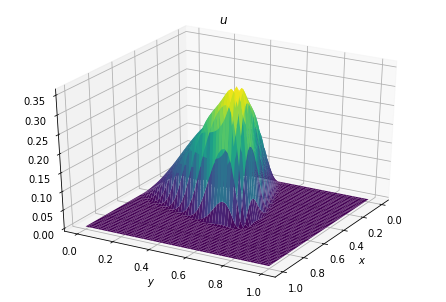

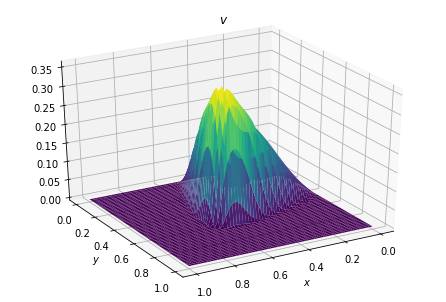

In [35]:
# plot
fig_u = plt.figure()
ax_u = Axes3D(fig_u)
ax_u.plot_surface(x.reshape(ny,nx), y.reshape(ny,nx), u_rom_pg[-1].reshape(ny,nx),cmap=cm.viridis, rstride=1, cstride=1)
ax_u.view_init(elev=30,azim=30)
ax_u.set_xlabel('$x$')
ax_u.set_ylabel('$y$')
plt.title('$u$')
plt.show()

fig_v = plt.figure()
ax_v = Axes3D(fig_v)
ax_v.plot_surface(x.reshape(ny,nx), y.reshape(ny,nx), v_rom_pg[-1].reshape(ny,nx),cmap=cm.viridis, rstride=1, cstride=1)
ax_v.view_init(elev=30,azim=60)
ax_v.set_xlabel('$x$')
ax_v.set_ylabel('$y$')
plt.title('$v$')
plt.show()

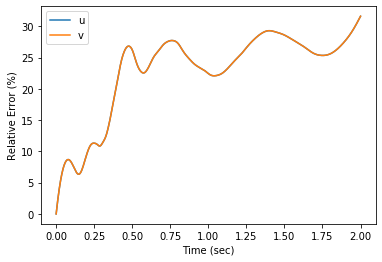

average relative error of u: 19.307603576830548%
average relative error of v: 19.307603576830775%

maximum relative error of u: 31.59547795582948%
maximum relative error of v: 31.59547795583238%


In [36]:
u_rel_err=np.linalg.norm(u_full-u_rom_pg,ord=2,axis=1)/np.linalg.norm(u_full,ord=2,axis=1)*100
v_rel_err=np.linalg.norm(v_full-v_rom_pg,ord=2,axis=1)/np.linalg.norm(v_full,ord=2,axis=1)*100
plt.plot(dt*np.arange(nt+1),u_rel_err,dt*np.arange(nt+1),v_rel_err)
plt.xlabel('Time (sec)')
plt.ylabel('Relative Error (%)')
plt.legend(('u','v'))
plt.show()

u_avg_rel_err=np.sqrt(np.sum(np.linalg.norm(u_full-u_rom_pg,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(u_full,ord=2,axis=1)**2))*100
v_avg_rel_err=np.sqrt(np.sum(np.linalg.norm(v_full-v_rom_pg,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(v_full,ord=2,axis=1)**2))*100

print("average relative error of u: {}%".format(u_avg_rel_err))
print("average relative error of v: {}%".format(v_avg_rel_err))
print()
print("maximum relative error of u: {}%".format(np.max(u_rel_err)))
print("maximum relative error of v: {}%".format(np.max(v_rel_err)))

In [37]:
# speed-up
speed_up=t_elapsed/t_elapsed_pg
print("speed-up: {}".format(speed_up))

speed-up: 0.05962021971441905


## DEIM

In [30]:
def DEIM(phi_f, nfeval=None):
    
    ninf=np.NINF
    n,m=np.shape(phi_f)
    if nfeval==None:
        nfeval=m
        
    if nfeval<m:
        print("ill-posed\n")
        print("set # sampling equal to # modes")
        nfeval=m
        
    div,mod=np.divmod(nfeval,m)
    
    I=np.eye(n)
    
    l=0
    ns=div+mod
    u=np.reshape(phi_f[:,l],(n,1))
    p=np.argsort(-np.abs(u),axis=0,kind='stable')[:ns]
#     p=np.argmax(np.abs(u)) # when ns=1
    ep=np.reshape(I[:,p],(n,ns))
    U=u
    P=ep

    ns=div
    for l in range(1,m):
        u=np.reshape(phi_f[:,l],(n,1))
        PT=np.transpose(P)
        c=np.linalg.lstsq(PT@U,PT@u,rcond=None)[0]
        r=np.abs(u-U@c)
        r[p]=ninf
        p=np.append(p,np.argsort(-r,axis=0,kind='stable')[:ns]) # ns!=1
        ep=np.reshape(I[:,p[-ns:]],(n,ns))
        U=np.concatenate((U,u),axis=1)
        P=np.concatenate((P,ep),axis=1)
        
    return p

In [31]:
# choose # of DEIM basis and DEIM samples
if Re==10000:
    DEIM_basis=59
    DEIM_samples=59
elif Re==100:
    DEIM_basis=50
    DEIM_samples=50
else:
    raise NameError('{} is given for Re, but it must be either 100 or 10000'.format(Re))

In [32]:
# choose # of DEIM basis file name
if Re==10000:
    file_name="./data/snapshot_full_high_Re.p"
    file_name_inter="./data/snapshot_full_inter_high_Re.p"
elif Re==100:
    file_name="./data/snapshot_full_low_Re.p"
    file_name_inter="./data/snapshot_full_inter_low_Re.p"
else:
    raise NameError('{} is given for Re, but it must be either 100 or 10000'.format(Re))

In [33]:
# load sanpshots
# # snapshot: just full order solution
# snapshot = pickle.load(open(file_name,'rb'))
# snapshot_u_orig = snapshot['u']
# snapshot_v_orig = snapshot['v']

# ndata = snapshot_u_orig.shape[0]
# nset = round(ndata/(nt+1))
# data_ind = np.array([],dtype='int')
# for foo in range(nset):
#     data_ind = np.append(data_ind,np.arange(foo*(nt+1)+1,(foo+1)*(nt+1)))

# snapshot_theta_u=np.zeros((nset*nt,nxy))
# snapshot_theta_v=np.zeros((nset*nt,nxy))

# for foo in range(nset*nt):
#     k = data_ind[foo]
#     u_tilde=snapshot_u_orig[k,free_raveled_indicies]-u_ref
#     v_tilde=snapshot_v_orig[k,free_raveled_indicies]-v_ref
    
#     snapshot_theta_u[foo]=-1/dx*u_tilde*M.dot(u_tilde)-1/dy*v_tilde*N.dot(u_tilde)
#     snapshot_theta_v[foo]=-1/dx*u_tilde*M.dot(v_tilde)-1/dy*v_tilde*N.dot(v_tilde)

# snapshot: full order solution including intermediate values
snapshot = pickle.load(open(file_name_inter,'rb'))
snapshot_u_orig = snapshot['u']
snapshot_v_orig = snapshot['v']

ndata = snapshot_u_orig.shape[0]

snapshot_theta_u=np.zeros((ndata,nxy))
snapshot_theta_v=np.zeros((ndata,nxy))

for k in range(ndata):
    u_tilde=snapshot_u_orig[k]-u_ref
    v_tilde=snapshot_v_orig[k]-v_ref
    
    snapshot_theta_u[k]=-1/dx*u_tilde*M.dot(u_tilde)-1/dy*v_tilde*N.dot(u_tilde)
    snapshot_theta_v[k]=-1/dx*u_tilde*M.dot(v_tilde)-1/dy*v_tilde*N.dot(v_tilde)

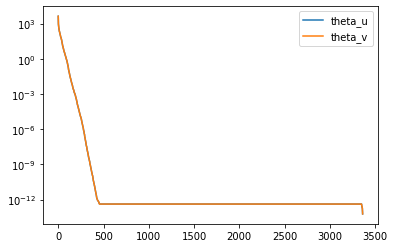

In [34]:
# do svd decomposition
U_theta_u,S_theta_u,V_theta_uT=np.linalg.svd(snapshot_theta_u.T,full_matrices=False)
U_theta_v,S_theta_v,V_theta_vT=np.linalg.svd(snapshot_theta_v.T,full_matrices=False)

plt.figure()
plt.semilogy(S_theta_u)
plt.semilogy(S_theta_v)
plt.legend(('theta_u','theta_v'))
plt.show()

In [35]:
acc_theta_u=np.sum(S_theta_u[:DEIM_basis]**2)/np.sum(S_theta_u**2)*100
acc_theta_v=np.sum(S_theta_v[:DEIM_basis]**2)/np.sum(S_theta_v**2)*100
print(acc_theta_u)
print(acc_theta_v)

phi_theta_u=U_theta_u[:,:DEIM_basis]
phi_theta_v=U_theta_v[:,:DEIM_basis]
print(phi_theta_u.shape)
print(phi_theta_v.shape)

99.99864117993152
99.99864117993151
(3364, 59)
(3364, 59)


In [36]:
print(np.sum(S_theta_u[:DEIM_basis])/np.sum(S_theta_u)*100)
print(np.sum(S_theta_v[:DEIM_basis])/np.sum(S_theta_v)*100)

99.27444503900082
99.27444503900084


In [37]:
# precompute
z_theta_u=DEIM(phi_theta_u,DEIM_samples)
z_theta_v=DEIM(phi_theta_v,DEIM_samples)

P_u=phi_theta_u.dot(np.linalg.pinv(phi_theta_u[z_theta_u]))
P_v=phi_theta_v.dot(np.linalg.pinv(phi_theta_v[z_theta_v]))
print(P_u.shape)
print(P_v.shape)

P_uT=P_u.T
P_vT=P_v.T

P_uTphi_u=P_uT.dot(phi_u)
P_uTP_u=P_uT.dot(P_u)

P_vTphi_v=P_vT.dot(phi_v)
P_vTP_v=P_vT.dot(P_v)

A2TP_u_cur=A2T_cur.dot(P_u)
B2TP_v_cur=B2T_cur.dot(P_v)

A3TP_u_cur=A3T_cur.dot(P_u)
B3TP_v_cur=B3T_cur.dot(P_v)

P_uTa1_cur=P_uT.dot(a1_cur)
P_uTA2_cur=P_uT.dot(A2_cur)
P_uTA3_cur=P_uT.dot(A3_cur)

P_vTb1_cur=P_vT.dot(b1_cur)
P_vTB2_cur=P_vT.dot(B2_cur)
P_vTB3_cur=P_vT.dot(B3_cur)

(3364, 59)
(3364, 59)


In [38]:
def ZTtheta_u(u_hat,v_hat):
    return -1/dx*phi_u[z_theta_u].dot(u_hat)*Mphi_u[z_theta_u].dot(u_hat)-1/dy*phi_v[z_theta_u].dot(v_hat)*Nphi_u[z_theta_u].dot(u_hat)

def ZTtheta_v(u_hat,v_hat):
    return -1/dx*phi_u[z_theta_v].dot(u_hat)*Mphi_v[z_theta_v].dot(v_hat)-1/dy*phi_v[z_theta_v].dot(v_hat)*Nphi_v[z_theta_v].dot(v_hat)

In [39]:
def dZTtheta_udu_hat(u_hat,v_hat):
    return -1/dx*(np.diag(Mphi_u[z_theta_u].dot(u_hat)).dot(phi_u[z_theta_u])+np.diag(phi_u[z_theta_u].dot(u_hat)).dot(Mphi_u[z_theta_u])) \
-1/dy*(np.diag(phi_v[z_theta_u].dot(v_hat)).dot(Nphi_u[z_theta_u]))

def dZTtheta_udv_hat(u_hat,v_hat):
    return -1/dy*(np.diag(Nphi_u[z_theta_u].dot(u_hat)).dot(phi_v[z_theta_u]))

def dZTtheta_vdu_hat(u_hat,v_hat):
    return -1/dx*(np.diag(Mphi_v[z_theta_v].dot(v_hat)).dot(phi_u[z_theta_v]))

def dZTtheta_vdv_hat(u_hat,v_hat):
    return -1/dx*(np.diag(phi_u[z_theta_v].dot(u_hat)).dot(Mphi_v[z_theta_v])) \
-1/dy*(np.diag(Nphi_v[z_theta_v].dot(v_hat)).dot(phi_v[z_theta_v])+np.diag(phi_v[z_theta_v].dot(v_hat)).dot(Nphi_v[z_theta_v]))

In [40]:
def dtheta_udu_hatTZ(u_hat,v_hat):
    return -1/dx*(Mphi_u[z_theta_u].dot(u_hat)*phi_uT[:,z_theta_u]+phi_u[z_theta_u].dot(u_hat)*Mphi_uT[:,z_theta_u]) \
-1/dy*(phi_v[z_theta_u].dot(v_hat)*Nphi_uT[:,z_theta_u])

def dtheta_udv_hatTZ(u_hat,v_hat):
    return -1/dy*(Nphi_u[z_theta_u].dot(u_hat)*phi_vT[:,z_theta_u])

def dtheta_vdu_hatTZ(u_hat,v_hat):
    return -1/dx*(Mphi_v[z_theta_v].dot(v_hat)*phi_uT[:,z_theta_v])

def dtheta_vdv_hatTZ(u_hat,v_hat):
    return -1/dx*(phi_u[z_theta_v].dot(u_hat)*Mphi_vT[:,z_theta_v]) \
-1/dy*(Nphi_v[z_theta_v].dot(v_hat)*phi_vT[:,z_theta_v]+phi_v[z_theta_v].dot(v_hat)*Nphi_vT[:,z_theta_v])

In [41]:
def r_hat_DEIM(u_hat,v_hat,u_hat_prev,v_hat_prev,A4_cur,A5_cur,a6_cur,A7_cur,A8_cur,B4_cur,B5_cur,b6_cur,B7_cur,B8_cur,\
               A2TP_u_cur,A3TP_u_cur,B2TP_v_cur,B3TP_v_cur,\
               P_uTa1_cur,P_uTA2_cur,P_uTA3_cur,P_vTb1_cur,P_vTB2_cur,P_vTB3_cur):
    
    r_u_hat=A4_cur.dot(u_hat_prev)+A5_cur.dot(v_hat_prev)+a6_cur+A7_cur.dot(u_hat)+A8_cur.dot(v_hat) \
    -dt*A2TP_u_cur.dot(ZTtheta_u(u_hat,v_hat))-dt*B2TP_v_cur.dot(ZTtheta_v(u_hat,v_hat)) \
    -dt*dtheta_udu_hatTZ(u_hat,v_hat).dot(-P_uTphi_u.dot(u_hat_prev)+P_uTa1_cur+P_uTA2_cur.dot(u_hat)+P_uTA3_cur.dot(v_hat)-dt*P_uTP_u.dot(ZTtheta_u(u_hat,v_hat))) \
    -dt*dtheta_vdu_hatTZ(u_hat,v_hat).dot(-P_vTphi_v.dot(v_hat_prev)+P_vTb1_cur+P_vTB2_cur.dot(u_hat)+P_vTB3_cur.dot(v_hat)-dt*P_vTP_v.dot(ZTtheta_v(u_hat,v_hat)))
    
    r_v_hat=B4_cur.dot(u_hat_prev)+B5_cur.dot(v_hat_prev)+b6_cur+B7_cur.dot(u_hat)+B8_cur.dot(v_hat) \
    -dt*A3TP_u_cur.dot(ZTtheta_u(u_hat,v_hat))-dt*B3TP_v_cur.dot(ZTtheta_v(u_hat,v_hat)) \
    -dt*dtheta_udv_hatTZ(u_hat,v_hat).dot(-P_uTphi_u.dot(u_hat_prev)+P_uTa1_cur+P_uTA2_cur.dot(u_hat)+P_uTA3_cur.dot(v_hat)-dt*P_uTP_u.dot(ZTtheta_u(u_hat,v_hat))) \
    -dt*dtheta_vdv_hatTZ(u_hat,v_hat).dot(-P_vTphi_v.dot(v_hat_prev)+P_vTb1_cur+P_vTB2_cur.dot(u_hat)+P_vTB3_cur.dot(v_hat)-dt*P_vTP_v.dot(ZTtheta_v(u_hat,v_hat)))
    
    return np.concatenate((r_u_hat,r_v_hat))

In [42]:
def J_hat_DEIM(u_hat,v_hat,P_uTA2_cur,A2TP_u_cur,P_uTA3_cur,A3TP_u_cur,A7_cur,A8_cur,\
               P_vTB2_cur,B2TP_v_cur,P_vTB3_cur,B3TP_v_cur,B7_cur,B8_cur):
    
    J_hat11=A7_cur-dt*A2TP_u_cur.dot(dZTtheta_udu_hat(u_hat,v_hat))-dt*B2TP_v_cur.dot(dZTtheta_vdu_hat(u_hat,v_hat)) \
    -dt*dtheta_udu_hatTZ(u_hat,v_hat).dot(P_uTA2_cur-dt*P_uTP_u.dot(dZTtheta_udu_hat(u_hat,v_hat))) \
    -dt*dtheta_vdu_hatTZ(u_hat,v_hat).dot(P_vTB2_cur-dt*P_vTP_v.dot(dZTtheta_vdu_hat(u_hat,v_hat)))
    
    J_hat12=A8_cur-dt*A2TP_u_cur.dot(dZTtheta_udv_hat(u_hat,v_hat))-dt*B2TP_v_cur.dot(dZTtheta_vdv_hat(u_hat,v_hat)) \
    -dt*dtheta_udu_hatTZ(u_hat,v_hat).dot(P_uTA3_cur-dt*P_uTP_u.dot(dZTtheta_udv_hat(u_hat,v_hat))) \
    -dt*dtheta_vdu_hatTZ(u_hat,v_hat).dot(P_vTB3_cur-dt*P_vTP_v.dot(dZTtheta_vdv_hat(u_hat,v_hat)))
    
    J_hat21=B7_cur-dt*A3TP_u_cur.dot(dZTtheta_udu_hat(u_hat,v_hat))-dt*B3TP_v_cur.dot(dZTtheta_vdu_hat(u_hat,v_hat)) \
    -dt*dtheta_udv_hatTZ(u_hat,v_hat).dot(P_uTA2_cur-dt*P_uTP_u.dot(dZTtheta_udu_hat(u_hat,v_hat))) \
    -dt*dtheta_vdv_hatTZ(u_hat,v_hat).dot(P_vTB2_cur-dt*P_vTP_v.dot(dZTtheta_vdu_hat(u_hat,v_hat)))
    
    J_hat22=B8_cur-dt*A3TP_u_cur.dot(dZTtheta_udv_hat(u_hat,v_hat))-dt*B3TP_v_cur.dot(dZTtheta_vdv_hat(u_hat,v_hat)) \
    -dt*dtheta_udv_hatTZ(u_hat,v_hat).dot(P_uTA3_cur-dt*P_uTP_u.dot(dZTtheta_udv_hat(u_hat,v_hat))) \
    -dt*dtheta_vdv_hatTZ(u_hat,v_hat).dot(P_vTB3_cur-dt*P_vTP_v.dot(dZTtheta_vdv_hat(u_hat,v_hat)))
    
    return np.block([[J_hat11,J_hat12],[J_hat21,J_hat22]])

In [43]:
t_start_pg_DEIM=time.time()

# solution
u_rom_pg_DEIM=np.zeros((nt+1,ny*nx))
v_rom_pg_DEIM=np.zeros((nt+1,ny*nx))
u_reduced=np.zeros((nt+1,POD_basis))
v_reduced=np.zeros((nt+1,POD_basis))

# IC
u_hat0=np.zeros(POD_basis)
v_hat0=np.zeros(POD_basis)
u_rom_pg_DEIM[0]=np.copy(u0)
v_rom_pg_DEIM[0]=np.copy(v0)

for k in range(nt):
#     print("")
#     print(k,"th time step:")
    
    u_hat_prev=np.copy(u_reduced[k])
    v_hat_prev=np.copy(v_reduced[k])
    
    u_hat=np.copy(u_reduced[k])
    v_hat=np.copy(v_reduced[k])
    
    residual_hat=r_hat_DEIM(u_hat,v_hat,u_hat_prev,v_hat_prev,A4_cur,A5_cur,a6_cur,A7_cur,A8_cur,B4_cur,B5_cur,b6_cur,B7_cur,B8_cur,\
                            A2TP_u_cur,A3TP_u_cur,B2TP_v_cur,B3TP_v_cur,\
                            P_uTa1_cur,P_uTA2_cur,P_uTA3_cur,P_vTb1_cur,P_vTB2_cur,P_vTB3_cur)
    
    for itr in range(maxitr):
        Jacobian_hat=J_hat_DEIM(u_hat,v_hat,P_uTA2_cur,A2TP_u_cur,P_uTA3_cur,A3TP_u_cur,A7_cur,A8_cur,\
                                P_vTB2_cur,B2TP_v_cur,P_vTB3_cur,B3TP_v_cur,B7_cur,B8_cur)
        
        delta_reduced=np.linalg.solve(Jacobian_hat,-residual_hat)
        
        u_hat+=delta_reduced[:POD_basis]
        v_hat+=delta_reduced[POD_basis:]
        
        residual_hat=r_hat_DEIM(u_hat,v_hat,u_hat_prev,v_hat_prev,A4_cur,A5_cur,a6_cur,A7_cur,A8_cur,B4_cur,B5_cur,b6_cur,B7_cur,B8_cur,\
                                A2TP_u_cur,A3TP_u_cur,B2TP_v_cur,B3TP_v_cur,\
                                P_uTa1_cur,P_uTA2_cur,P_uTA3_cur,P_vTb1_cur,P_vTB2_cur,P_vTB3_cur)
        
        R=np.linalg.norm(residual_hat)
#         print(itr,"th Newton iteration", "R:", R)
        
        if R<tol:
            u_reduced[k+1]=u_hat.copy()
            v_reduced[k+1]=v_hat.copy()
            u_rom_pg_DEIM[k+1,free_raveled_indicies]=u_ref+phi_u.dot(u_hat)
            v_rom_pg_DEIM[k+1,free_raveled_indicies]=v_ref+phi_v.dot(v_hat)
            # BC from exact solution
            u_rom_pg_DEIM[k+1,fixed_raveled_indicies]=u0[fixed_raveled_indicies].copy()
            v_rom_pg_DEIM[k+1,fixed_raveled_indicies]=v0[fixed_raveled_indicies].copy()
            break
            
    if R>=tol:
        print("\n non converged after {}th iteration".format(maxitr))
        break  

#     u_reduced[k+1]=u_hat.copy()
#     v_reduced[k+1]=v_hat.copy()
#     u_rom_g_DEIM[k+1,free_raveled_indicies]=u_ref+phi_u.dot(u_hat)
#     v_rom_g_DEIM[k+1,free_raveled_indicies]=v_ref+phi_v.dot(v_hat)
#     # BC from exact solution
#     u_rom_g_DEIM[k+1,fixed_raveled_indicies]=u0[fixed_raveled_indicies].copy()
#     v_rom_g_DEIM[k+1,fixed_raveled_indicies]=v0[fixed_raveled_indicies].copy()

t_elapsed_pg_DEIM=time.time()-t_start_pg_DEIM
print()
print('Time elapsed: {} sec'.format(t_elapsed_pg_DEIM))


Time elapsed: 4.411479711532593 sec


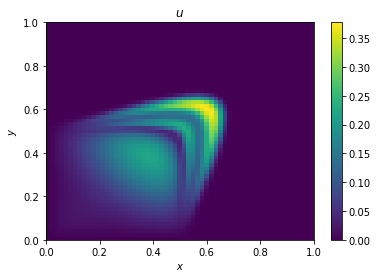

In [44]:
# plot
k=-1

fig_u = plt.figure()
# ax_u = Axes3D(fig_u)
# ax_u.plot_surface(x.reshape(ny,nx), y.reshape(ny,nx), (u_rom_pg_DEIM[k]).reshape(ny,nx),cmap=cm.viridis, rstride=1, cstride=1)
# ax_u.view_init(elev=30,azim=30)
ax_u = fig_u.gca()
p_u=ax_u.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), (u_rom_pg_DEIM[k]).reshape(ny,nx))
cb_u=fig_u.colorbar(p_u,ax=ax_u)
ax_u.set_xlabel('$x$')
ax_u.set_ylabel('$y$')
plt.title('$u$')
plt.show()

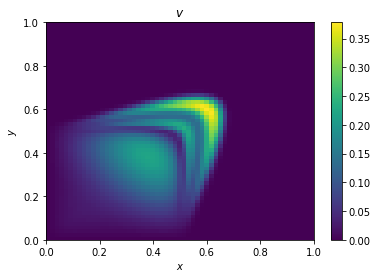

In [45]:
fig_v = plt.figure()
# ax_v = Axes3D(fig_v)
# ax_v.plot_surface(x.reshape(ny,nx), y.reshape(ny,nx), (v_rom_pg_DEIM[k]).reshape(ny,nx),cmap=cm.viridis, rstride=1, cstride=1)
# ax_v.view_init(elev=30,azim=60)
ax_v = fig_v.gca()
p_v=ax_v.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), (v_rom_pg_DEIM[k]).reshape(ny,nx))
cb_v=fig_v.colorbar(p_v,ax=ax_v)
ax_v.set_xlabel('$x$')
ax_v.set_ylabel('$y$')
plt.title('$v$')
plt.show()

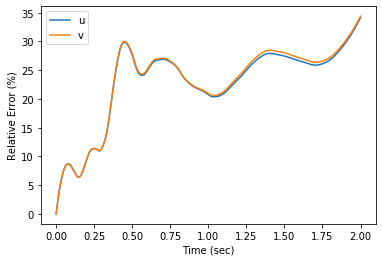

average relative error of u: 19.682570732373026%
average relative error of v: 19.873067084603367%

maximum relative error of u: 34.141324958403565%
maximum relative error of v: 34.377501067874014%


In [46]:
u_rel_err=np.linalg.norm(u_full-u_rom_pg_DEIM,ord=2,axis=1)/np.linalg.norm(u_full,ord=2,axis=1)*100
v_rel_err=np.linalg.norm(v_full-v_rom_pg_DEIM,ord=2,axis=1)/np.linalg.norm(v_full,ord=2,axis=1)*100
plt.plot(dt*np.arange(nt+1),u_rel_err,dt*np.arange(nt+1),v_rel_err)
plt.xlabel('Time (sec)')
plt.ylabel('Relative Error (%)')
plt.legend(('u','v'))
plt.show()

u_avg_rel_err=np.sqrt(np.sum(np.linalg.norm(u_full-u_rom_pg_DEIM,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(u_full,ord=2,axis=1)**2))*100
v_avg_rel_err=np.sqrt(np.sum(np.linalg.norm(v_full-v_rom_pg_DEIM,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(v_full,ord=2,axis=1)**2))*100

print("average relative error of u: {}%".format(u_avg_rel_err))
print("average relative error of v: {}%".format(v_avg_rel_err))
print()
print("maximum relative error of u: {}%".format(np.max(u_rel_err)))
print("maximum relative error of v: {}%".format(np.max(v_rel_err)))

In [54]:
# speed-up
speed_up=t_elapsed/t_elapsed_pg_DEIM
print("speed-up: {}".format(speed_up))

speed-up: 30.42919170502066


# Save data to mat file

In [55]:
ROM_pg_DEIM={'u_rom_lspg_hr':u_rom_pg_DEIM,'v_rom_lspg_hr':v_rom_pg_DEIM,'u':u_full,'v':v_full}

if Re==10000:
    file_name_ROM_pg_DEIM='./data/LSROM_high_Re.mat'
elif Re==100:
    file_name_ROM_pg_DEIM='./data/LSROM_low_Re.mat'
else:
    raise NameError('{} is given for Re, but it must be either 100 or 10000'.format(Re))

savemat(file_name_ROM_pg_DEIM, ROM_pg_DEIM)